<a href="https://colab.research.google.com/github/Noideded/Pneumonia-Detection/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install torchinfo

import torch
import torch.nn as nn
from torch.nn import functional as F
import requests
import os
from tqdm import tqdm

In [ ]:
from google.colab import files
import os
import shutil

# Upload the API key
uploaded = files.upload()  # Select your kaggle.json file

# Get the actual uploaded filename (handles spaces/numbers)
uploaded_filename = list(uploaded.keys())[0]

# Create .kaggle directory and copy the file
!mkdir -p ~/.kaggle
shutil.copy(uploaded_filename, '/root/.kaggle/kaggle.json')  # Renames to kaggle.json

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify
!ls -l ~/.kaggle/

Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 67 Dec  1 14:28 kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Critical for security

In [ ]:
#install

!pip install --upgrade --no-deps --force-reinstall tensorflow==2.19.0
!pip install tensorflow==2.19.0  # Reinstall with dependencies

In [ ]:
from google.colab import drive
import os
import glob

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --force

# Check for .zip files (handle versioned names)
downloaded_files = glob.glob("/content/*.zip")
if not downloaded_files:
    raise FileNotFoundError("No .zip file found. Kaggle download failed!")

downloaded_file = downloaded_files[0].split("/")[-1]
print(f"Downloaded: {downloaded_file}")

# Unzip the downloaded file
!unzip -q "/content/{downloaded_file}" -d "/content/chexpert_data"

# Verify the extraction
!ls "/content/chexpert_data"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:34<00:01, 15.7MB/s]
100% 2.29G/2.29G [00:34<00:00, 70.5MB/s]
Downloaded: chest-xray-pneumonia.zip
chest_xray


In [ ]:
!rm "/content/chest-xray-pneumonia.zip"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [ ]:
#check tensorflow version for preprocessing

import tensorflow as tf
print(tf.__version__) # 2.3.0 and above

2.19.0


In [ ]:
!ls "/content/chexpert_data/chest_xray/val"  # Should show "NORMAL/" and "PNEUMONIA/"

NORMAL	PNEUMONIA


In [ ]:
import os, shutil

original_dirs = ["/content/chexpert_data/chest_xray/train",
                 "/content/chexpert_data/chest_xray/val",
                 "/content/chexpert_data/chest_xray/test"]

merged_dir = "merged_dataset"
os.makedirs(merged_dir, exist_ok=True)

for src_dir in original_dirs:
    for cls in os.listdir(src_dir):  # NORMAL, PNEUMONIA
        cls_path = os.path.join(src_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        dst_cls_path = os.path.join(merged_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)

        for fname in os.listdir(cls_path):
            src = os.path.join(cls_path, fname)
            dst = os.path.join(dst_cls_path, fname)
            if not os.path.exists(dst):  # avoid duplicates
                shutil.copy(src, dst)


In [ ]:
import os
from sklearn.model_selection import train_test_split

merged_dir = "merged_dataset"
output_base = "final_dataset"

train_dir = os.path.join(output_base, "train")
val_dir = os.path.join(output_base, "val")
test_dir = os.path.join(output_base, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

for cls in os.listdir(merged_dir):
    cls_path = os.path.join(merged_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)

    train_files, temp_files = train_test_split(
        images, test_size = 0.3, random_state = 42
    )

    val_files, test_files = train_test_split(
        temp_files, test_size = 0.5, random_state = 42
    )

    for fname in train_files:
      src = os.path.join(cls_path, fname)
      dst = os.path.join(train_dir, cls, fname)
      os.makedirs(os.path.dirname(dst), exist_ok=True)
      shutil.copy(src, dst)

    for fname in val_files:
      src = os.path.join(cls_path, fname)
      dst = os.path.join(val_dir, cls, fname)
      os.makedirs(os.path.dirname(dst), exist_ok=True)
      shutil.copy(src, dst)

      for fname in test_files:
        src = os.path.join(cls_path, fname)
        dst = os.path.join(test_dir, cls, fname)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset successfully split")

def summarize_dataset(base_dir):
  print(f"\nSummary for {base_dir}")
  for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
          count = len(os.listdir(cls_path))
          print(f"  {cls}: {count} images")

summarize_dataset(train_dir)
summarize_dataset(val_dir)
summarize_dataset(test_dir)






Dataset successfully split

Summary for final_dataset/train
  PNEUMONIA: 2991 images
  NORMAL: 1108 images

Summary for final_dataset/val
  PNEUMONIA: 641 images
  NORMAL: 237 images

Summary for final_dataset/test
  PNEUMONIA: 641 images
  NORMAL: 238 images


In [ ]:
import os

print("Subfolders in train_dir:", os.listdir(train_dir))
for sub in os.listdir(train_dir):
    print(sub, "->", len(os.listdir(os.path.join(train_dir, sub))), "files")


Subfolders in train_dir: ['PNEUMONIA', 'NORMAL']
PNEUMONIA -> 2991 files
NORMAL -> 1108 files


In [ ]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = "binary",
    shuffle = True,
    seed = 42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = "binary",
    shuffle = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = "binary",
    shuffle = False
)

def get_labels_safely(dataset):
  label_ds = dataset.map(lambda x, y: y)

  labels_lists = []
  for batch_labels in label_ds:
    batch_np = batch_labels.numpy()
    if batch_np.ndim > 1:
      batch_np = batch_np.flatten()
    labels_lists.extend(batch_np)

  return np.array(labels_lists)

train_labels = get_labels_safely(train_ds)
val_labels = get_labels_safely(val_ds)
test_labels = get_labels_safely(test_ds)

def count(dataset):
  return sum(1 for _ in dataset.unbatch())

  print("Training images:", count_images(train_ds), "images")
  print("Validation images:", count_images(val_ds), "images")
  print("Test images:", count_images(test_ds), "images")
  print("Classes:", train_ds.class_names)


Found 4099 files belonging to 2 classes.
Found 878 files belonging to 2 classes.
Found 879 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
import os


# Classes found
print("Classes:", train_ds.class_names)

# Helper: count per class
def count_per_class(dataset):
    class_counts = dict.fromkeys(range(len(train_ds.class_names)), 0)
    for _, labels in dataset.unbatch():
        lbl_value = labels.numpy()
        lbl = int(lbl_value.item())
        class_counts[lbl] += 1
    return class_counts

# Count per class for train, val
train_counts = count_per_class(train_ds)
val_counts = count_per_class(val_ds)
test_counts = count_per_class(test_ds)

# Print counts per class
print("\nTrain counts per class:")
for idx, cls in enumerate(train_ds.class_names):
    print(f"{cls} -> {train_counts[idx]}")

print("\nVal counts per class:")
for idx, cls in enumerate(val_ds.class_names):
    print(f"{cls} -> {val_counts[idx]}")

print("/nTrain counts per class:")
for idx, cls in enumerate(test_ds.class_names):
    print(f"{cls} -> {test_counts[idx]}")


Classes: ['NORMAL', 'PNEUMONIA']

Train counts per class:
NORMAL -> 1108
PNEUMONIA -> 2991

Val counts per class:
NORMAL -> 237
PNEUMONIA -> 641
/nTrain counts per class:
NORMAL -> 238
PNEUMONIA -> 641


In [ ]:
%matplotlib inline
import seaborn as sns

import tensorflow_hub as hub
import tensorflow as tf

Image batch shape: (32, 224, 224, 3)
Pixel value range: (np.float32(0.0), np.float32(255.0))
Unique labels: [1 0]
Label counts: [20 12]


<Figure size 1000x1000 with 0 Axes>

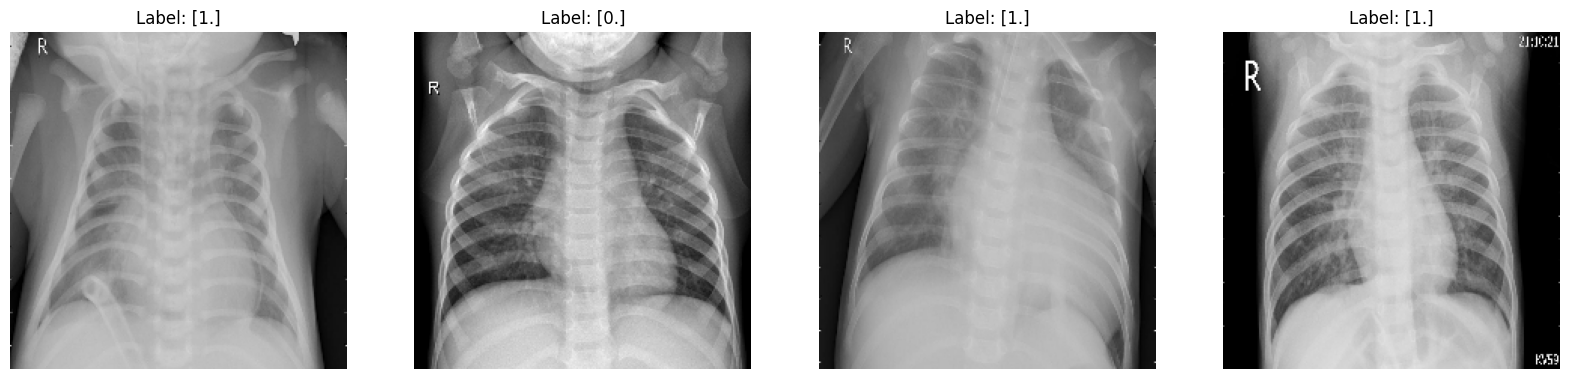

In [ ]:
import matplotlib.pyplot as plt

for X, y in train_ds.take(1):
  break

print("Image batch shape:", X.shape)
print("Pixel value range:", (tf.reduce_min(X).numpy(), tf.reduce_max(X).numpy()))

#uniqe labels and counts using tensorflow ops

unique_labels, _, label_counts = tf.unique_with_counts(tf.cast(tf.reshape(y, [-1]), tf.int32))
print("Unique labels:", unique_labels.numpy())
print("Label counts:", label_counts.numpy())

batch = next(train_ds.as_numpy_iterator())
images, labels = batch

plt.figure(figsize = (10, 10))

#plot first 4 images
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20 ))
for idx in range(4):
  img = images[idx]
  ax[idx].imshow(tf.cast(img, tf.uint8))
  ax[idx].set_title(f"Label: {labels[idx]}")
  ax[idx].axis('off')

In [ ]:
medical_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
  ])

heavy_augment =tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomBrightness(0.15),
    tf.keras.layers.RandomContrast(0.15),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
  ])

def aug_norm(images, labels):

  labels_exp = tf.cast(tf.reshape(labels, (-1, 1, 1, 1)), tf.float32)
  norm_images = heavy_augment(images, training = True)

  prob = tf.random.uniform(tf.shape(labels), 0, 1)
  prob = tf.cast(tf.reshape(prob, (-1, 1, 1, 1)), tf.float32)
  pneu_images = medical_augmentation(images, training = True)

  pneu_images = tf.where(prob < 0.3, pneu_images, images)

  final_images = tf.where(labels_exp == 0.0, norm_images, pneu_images)

  return final_images, labels


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
base_model = EfficientNetV2B0(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3),
    pooling = None)

base_model.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add new layers for binary classification (NORMAL vs. PNEUMONIA)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces spatial dimensions to 1x1
x = Dense(128, activation='swish')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary output

# Combine base model + new head
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer = Adam(learning_rate = 1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
from time import thread_time
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, precision_recall_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#class weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_labels),
    y = train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights: ", class_weight_dict)

early_stopper = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor = 'val_loss', mode = 'min', save_best_only = True, verbose=1)

#train
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    class_weight = class_weight_dict,
    callbacks = [early_stopper, checkpoint],
    verbose = 1
)

val_probs = model.predict(val_ds, steps = len(val_ds), verbose = 1)
precision, recall, thresholds = precision_recall_curve(val_labels, val_probs.ravel())
optimal_idx = np.argmin(np.abs(precision - recall))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Training stopped at epoch {len(history.history['loss'])}")

# C. Final evaluation on TEST data
test_probs = model.predict(test_ds, steps = len(test_ds), verbose = 1)
y_pred = (test_probs.ravel() > optimal_threshold).astype(int)
print(classification_report(test_labels, y_pred))

Class weights:  {0: np.float64(1.8497292418772564), 1: np.float64(0.6852223336676697)}
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8528 - loss: 0.3010 - precision: 0.9470 - recall: 0.8354
Epoch 1: val_loss improved from inf to 0.12203, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.8532 - loss: 0.3003 - precision: 0.9472 - recall: 0.8359 - val_accuracy: 0.9544 - val_loss: 0.1220 - val_precision: 0.9732 - val_recall: 0.9641
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9520 - loss: 0.1269 - precision: 0.9830 - recall: 0.9496
Epoch 2: val_loss improved from 0.12203 to 0.11914, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.9520 - loss: 0.1269 - precision: 0.9830 - recall: 0.9496 - val_accuracy: 0.9567 - val_loss: 0.1191 - val_precision: 0.9575 - val_recall: 0.9844
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9334 - loss: 0.1519 - precision: 0.9681 - recall: 0.9381
Epoch 3: val_loss did not improve from 0.11914
129/129 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.9335 - loss: 0.1517 - precision: 0.9682 - recall: 0.9382 - val_accuracy: 0.9499 - val_loss: 0.1234 - val_precision: 0.9854 - val_recall: 0.9454
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9577 - loss: 0.1033 - precision: 0.9877 - recall: 0.9523
Epoch 4: val_loss improved from 0.11914 to 0.10640, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.9577 - loss: 0.1033 - precision: 0.9877 - recall: 0.9523 - val_accuracy: 0.9567 - val_loss: 0.1064 - val_precision: 0.9824 - val_recall: 0.9579
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9560 - loss: 0.1108 - precision: 0.9822 - recall: 0.9558
Epoch 5: val_loss did not improve from 0.10640
129/129 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.9560 - loss: 0.1107 - precision: 0.9822 - recall: 0.9559 - val_accuracy: 0.9567 - val_loss: 0.1145 - val_precision: 0.9561 - val_recall: 0.9860
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9566 - loss: 0.1127 - precision: 0.9834 - recall: 0.9556
Epoch 6: val_loss improved from 0.10640 to 0.09945, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9566 - loss: 0.1126 - precision: 0.9834 - recall: 0.9556 - val_accuracy: 0.9636 - val_loss: 0.0995 - val_precision: 0.9721 - val_recall: 0.9782
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - loss: 0.0795 - precision: 0.9864 - recall: 0.9680
Epoch 7: val_loss did not improve from 0.09945
129/129 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.9674 - loss: 0.0795 - precision: 0.9864 - recall: 0.9680 - val_accuracy: 0.9601 - val_loss: 0.1042 - val_precision: 0.9825 - val_recall: 0.9626
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9715 - loss: 0.0821 - precision: 0.9879 - recall: 0.9723
Epoch 8: val_loss did not improve from 0.09945
129/129 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.9715 - loss: 0.0821 - precision: 0.9879 - recall: 0.9723 - val_accuracy: 0.9510 - val_loss: 0.1163 - val_precision: 0.9870 - val_recall: 0.9454
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy:

129/129 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.9747 - loss: 0.0712 - precision: 0.9932 - recall: 0.9717 - val_accuracy: 0.9613 - val_loss: 0.0966 - val_precision: 0.9676 - val_recall: 0.9797
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9707 - loss: 0.0805 - precision: 0.9868 - recall: 0.9724
Epoch 10: val_loss improved from 0.09657 to 0.09106, saving model to best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.9707 - loss: 0.0805 - precision: 0.9868 - recall: 0.9724 - val_accuracy: 0.9636 - val_loss: 0.0911 - val_precision: 0.9692 - val_recall: 0.9813
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9693 - loss: 0.0807 - precision: 0.9875 - recall: 0.9693
Epoch 11: val_loss did not improve from 0.09106
129/129 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.9693 - loss: 0.0807 - precision: 0.9876 - recall: 0.9693 - val_accuracy: 0.9579 - val_loss: 0.0918 - val_precision: 0.9748 - val_recall: 0.9672
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9722 - loss: 0.0770 - precision: 0.9884 - recall: 0.9729
Epoch 12: val_loss did not improve from 0.09106
129/129 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9722 - loss: 0.0770 - precision: 0.9884 - recall: 0.9729 - val_accuracy: 0.9544 - val_loss: 0.1163 - val_precision: 0.9870 - val_recall: 0.9501
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

129/129 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.9753 - loss: 0.0635 - precision: 0.9913 - recall: 0.9741 - val_accuracy: 0.9715 - val_loss: 0.0883 - val_precision: 0.9873 - val_recall: 0.9735
Epoch 15/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9759 - loss: 0.0663 - precision: 0.9903 - recall: 0.9762
Epoch 15: val_loss did not improve from 0.08827
129/129 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.9759 - loss: 0.0663 - precision: 0.9903 - recall: 0.9762 - val_accuracy: 0.9647 - val_loss: 0.0922 - val_precision: 0.9766 - val_recall: 0.9750
Epoch 16/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9744 - loss: 0.0684 - precision: 0.9873 - recall: 0.9767
Epoch 16: val_loss did not improve from 0.08827
129/129 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.9744 - loss: 0.0684 - precision: 0.9874 - recall: 0.9767 - val_accuracy: 0.9658 - val_loss: 0.1022 - val_precision: 0.9650 - val_recall: 0.9891
Epoch 17/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

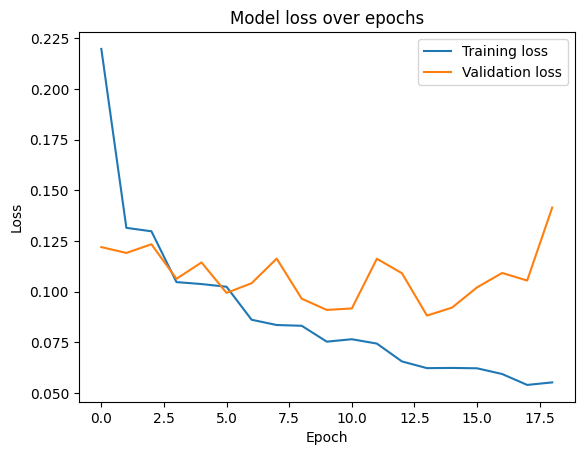

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(val_generator, steps=len(val_generator))
y_pred = (y_pred > 0.5).astype(int)

y_true = []
for i in range(len(val_generator)):
  _, y_batch = val_generator[i]
  y_true.extend(y_batch)

print(classification_report(y_true, y_pred))
print("Confusion_matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_pred))

NameError: name 'val_generator' is not defined